# Systèmes de recommandation : les données MovieLens

Nous nous intéressons à la base de données MovieLens. Des utilisateurs ont noté des items (films). Dans cette première partie, il s'agit d'analyser les données, définir une métrique entre items, et ranger les items similaires à un film donnée par ordre décroissant de similarité.
<font color="red">
Faire les imports habituels (numpy, pandas)</font>

In [1]:
import numpy as np
import pandas as pd

In [2]:
# Chargement des données (on précise que les séparateurs sont des tabulations)
column_names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('u.data', sep='\t', names=column_names)

<font color="red">
Afficher les premières lignes de la dataframe, et comprendre sa structure.</font>

In [3]:
df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


<font color="red">
Evaluer le nombre d'uilisateurs uniques, le nombre d'items uniques.</font>

In [4]:
# Nombre d'utilisateurs, nombre de films
n_user = df['user_id'].nunique()
n_item = df['item_id'].nunique()
print('n_user =',n_user)
print('n_item =',n_item)

n_user = 943
n_item = 1682


<font color="red">
Le fichier "../data/Movie_Id_Titles" contient la correspondance entre l'item_id et le titre du film. Charger ce fichier avec read_csv, et afficher les première lignes.</font>

In [6]:
# Chargement des titres de film
movie_titles = pd.read_csv("Movie_Id_Titles")
movie_titles.head()

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


<font color="red">
Avec df.merge, ajouter une colonne "title" à la dataframe df : on fixera le paramètre on=".." à la bonne valeur.
</font>

In [7]:
# Ajout d'une colonne de titres aux données
df = df.merge(movie_titles,on='item_id')
df.head()

,user_id,item_id,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


<font color="red">
Avec groupby, créer une nouvelle dataframe 'rating_movies' contenant la note moyenne de chaque film. 
Afficher le résultat en classant les films par ordre décroissant de note. Quels sont les films les mieux notés ?</font>

In [8]:
rating_movies = pd.DataFrame(df.groupby('title')['rating'].mean())
rating_movies.sort_values(by = 'rating',ascending=False).head(10)

,rating
title,
They Made Me a Criminal (1939),5.0
Marlene Dietrich: Shadow and Light (1996),5.0
"Saint of Fort Washington, The (1993)",5.0
Someone Else's America (1995),5.0
Star Kid (1997),5.0
"Great Day in Harlem, A (1994)",5.0
Aiqing wansui (1994),5.0
Santa with Muscles (1996),5.0
Prefontaine (1997),5.0


<font color="red">
Représenter l'histogramme des notes moyennes des films. A quoi correspondent les "pics" en 1 et en 5 ?</font>

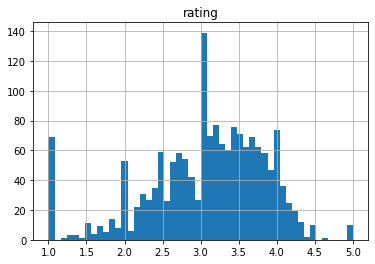

In [9]:
import matplotlib as plt
%matplotlib inline

rating_movies.hist(bins=50);

- Quelques navets ont une note moyenne de 1
- Quelques films ont une note moyenne de 5, probablement de bons films, mais confidentiels

<font color="red">
Ajouter à la dataframe 'rating_movies' une nouvelle colonne 'num of ratings' contenant le nombre de notes de chaque film. Que peut-on dire des films les mieux notés en moyenne ?</font>

In [10]:
rating_movies['num of ratings'] = df.groupby('title')['rating'].count()
rating_movies.sort_values(by='rating',ascending=False).head()

,rating,num of ratings
title,,
They Made Me a Criminal (1939),5.0,1
Marlene Dietrich: Shadow and Light (1996),5.0,1
"Saint of Fort Washington, The (1993)",5.0,2
Someone Else's America (1995),5.0,1
Star Kid (1997),5.0,3


Cela confirme que les films les mieux notés ont peu de notes.

<font color="red">
Afficher les titres de films ayant le plus de notes et discuter leur ratings.
</font>

In [11]:
rating_movies.sort_values(by='num of ratings',ascending=False).head()

,rating,num of ratings
title,,
Star Wars (1977),4.358491,583
Contact (1997),3.803536,509
Fargo (1996),4.155512,508
Return of the Jedi (1983),4.007890,507
Liar Liar (1997),3.156701,485


<font color="red">
Représenter la distribution du nombre de ratings.</font>

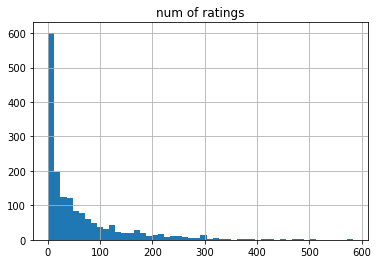

In [12]:
rating_movies.hist(column='num of ratings', bins=50);

Beaucoup de films (600 sur 1682) ont très peu de notes

<font color="red">
Avec sns.jointplot, représenter le nuage de points (note moyenne, nombre de notes) sur l'ensemble des film (utiliser le paramètre alpha= de votre choix).  
Discuter le graphique.
</font>

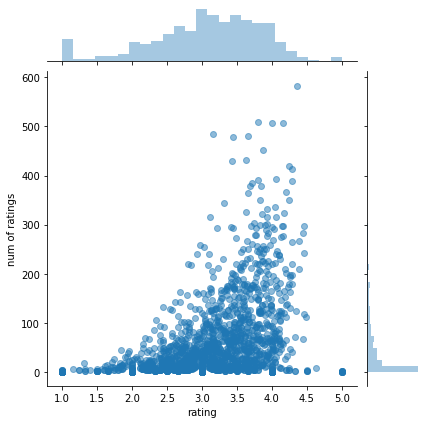

In [13]:
import seaborn as sns
sns.jointplot(x='rating',y='num of ratings',data=rating_movies,alpha=0.5);

- On retrouve le fait que les films ayant pour note moyenne 1 ou 5 sont les films peu notés
- Tendance : les films biens notés sont globalement les films beaucoup notés
- Un film beaucoup noté ne peut avoir une note très proche de 5

### Films les plus similaires à un item 
Dans cette partie, on se fixe un item, disons 'Star Wars (1977)'. On souhaite trouver des films "similaires" à Star Wars, et les classer par ordre de similarité, afin de les recommander.  
<font color="red">
Avec df.pivot_table, créer la matrice des intteractions, dont les indices sont les lignes correspondent aux user_id, les colonnes correspondent aux item_id, et dont les entrées sont les ratings.
</font>

In [14]:
moviemat = df.pivot_table(values='rating',index='user_id',columns='title')

<font color="red">
Extraire la colonne 'Star Wars (1977)'
</font>

In [15]:
starwars_user_ratings = moviemat['Star Wars (1977)']

<font color="red">
Avec la méthode .corr, calculer la corrélation de cette colonne avec la colonne 'Liar Liar (1997)'
</font>

In [16]:
liarliar_user_ratings = moviemat['Liar Liar (1997)']
starwars_user_ratings.corr(liarliar_user_ratings)

0.1502917685035789

<font color="red">
Que fournit le résultat de la méthode corrwith() ci-dessous ?
</font>

In [17]:
moviemat.corrwith(starwars_user_ratings)

/Users/thibaultallart/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/thibaultallart/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


title
'Til There Was You (1997)                0.872872
1-900 (1994)                            -0.645497
101 Dalmatians (1996)                    0.211132
12 Angry Men (1957)                      0.184289
187 (1997)                               0.027398
                                           ...   
Young Guns II (1990)                     0.228615
Young Poisoner's Handbook, The (1995)   -0.007374
Zeus and Roxanne (1997)                  0.818182
unknown                                  0.723123
Á köldum klaka (Cold Fever) (1994)            NaN
Length: 1664, dtype: float64

<font color="red">
Transformer la série ci-dessus en dataframe, et afficher les titres de film par ordre croissant de leur corrélation avec starwars.  
Discuter le résultat.</font>

In [18]:
similar_to_starwars = pd.DataFrame(moviemat.corrwith(starwars_user_ratings),columns=['Corr'])
similar_to_starwars.sort_values(by='Corr',ascending=False).head(10)

,Corr
title,
Hollow Reed (1996),1.0
Commandments (1997),1.0
Cosi (1996),1.0
No Escape (1994),1.0
Stripes (1981),1.0
Star Wars (1977),1.0
Man of the Year (1995),1.0
"Beans of Egypt, Maine, The (1994)",1.0
"Old Lady Who Walked in the Sea, The (Vieille qui marchait dans la mer, La) (1991)",1.0


Le problème est que les corrélations sont calculées sur les valeurs non NaN

Si un film a reçu la note r d'un seul utilisateur, et que cet utilisateur a noté r starwars, la corrélation vaut 1

Pour éviter cela, on va rechercher la corrélation parmi les films ayant plus de 100 ratings

<font color="red">
Ajouter à la dataframe similar_to_starwars une nouvelle colonne correspondant au nombre ratings de chaque film.</font>

In [19]:
similar_to_starwars['num of ratings'] = rating_movies['num of ratings']

<font color="red">
Filtrer les lignes pour n'afficher que les titres ayant un nombre de ratings "suffisant" pour que vous les reteniez dans le classement.
</font>

In [20]:
most_similar_movies = similar_to_starwars[similar_to_starwars['num of ratings']>100]
most_similar_movies.sort_values(by='Corr',ascending=False,inplace=True)
most_similar_movies.head(10)

/Users/thibaultallart/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Corr,num of ratings
title,,
Star Wars (1977),1.000000,583
"Empire Strikes Back, The (1980)",0.747981,367
Return of the Jedi (1983),0.672556,507
Raiders of the Lost Ark (1981),0.536117,420
Austin Powers: International Man of Mystery (1997),0.377433,130
"Sting, The (1973)",0.367538,241
Indiana Jones and the Last Crusade (1989),0.350107,331
Pinocchio (1940),0.347868,101
"Frighteners, The (1996)",0.332729,115


<font color="red">
Si ce n'est fait, effectuer le classement par valeurs décroissantes de corrélation en mode "inplace".  
Puis, grâce à reset_index, obtenir une nouvelle colonne correspondant au classement de chaque film.</font>

In [21]:
most_similar_movies.reset_index(inplace=True)
most_similar_movies.head(10)

,title,Corr,num of ratings
0,Star Wars (1977),1.000000,583
1,"Empire Strikes Back, The (1980)",0.747981,367
2,Return of the Jedi (1983),0.672556,507
3,Raiders of the Lost Ark (1981),0.536117,420
4,Austin Powers: International Man of Mystery (1...,0.377433,130
5,"Sting, The (1973)",0.367538,241
6,Indiana Jones and the Last Crusade (1989),0.350107,331
7,Pinocchio (1940),0.347868,101
8,"Frighteners, The (1996)",0.332729,115
9,L.A. Confidential (1997),0.319065,297


<font color="red">
Dans ce classement par similarité, quel est le rang du film 'Batman (1989)' ?
</font>

In [22]:
most_similar_movies[most_similar_movies.title == 'Batman (1989)']

,title,Corr,num of ratings
18,Batman (1989),0.289344,201
